In [1]:
import torch
from easy_transformer import EasyTransformer

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2', device=device)

# Convenience function for decoding token
decode = model.tokenizer.decode

# Convenience function for encoding token
def encode(t):
    global model
    result = model.tokenizer.encode(t)
    if len(result) != 1:
        raise Exception(f"Not a single token: {t}")
    return result[0]

unembed = model.unembed.W_U.data
embed = model.embed.W_E.data
d_M = model.cfg.d_model
d_V = model.cfg.d_vocab

unembed_norm = torch.nn.functional.normalize(unembed, dim=0)

Using cpu device
Loading model: gpt2


Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!


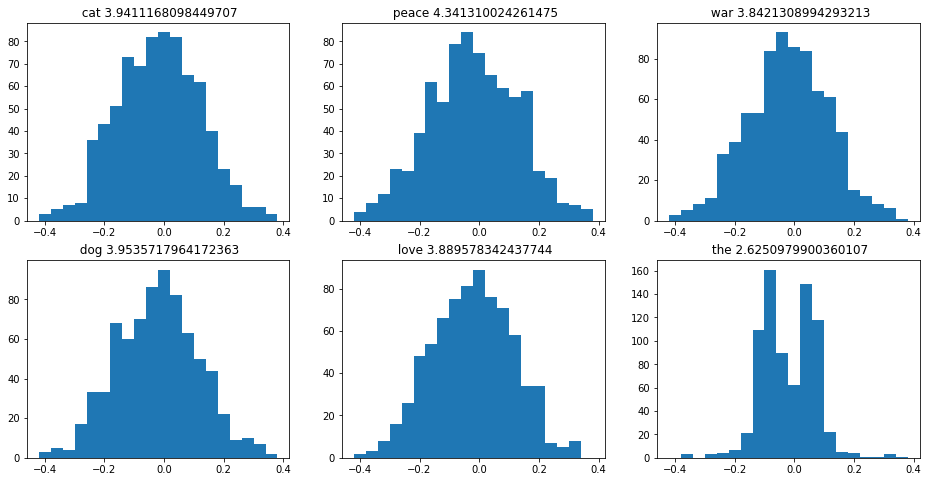

In [22]:
import matplotlib.pyplot as plt
toks = [' cat', ' dog', ' peace', ' love', ' war', ' the']
n_bins = 20

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(2,3)

for i, tok in enumerate(toks):
    t = encode(tok)
    v = unembed[:,t]
    hist, bin_edges = torch.histogram(v, n_bins, range=(-0.4, 0.4))
    ax[i % 2][i // 2].bar(bin_edges[:-1], hist, bin_edges[1:] - bin_edges[:-1])
    metric = torch.linalg.vector_norm(v, 2, dim=0)
    ax[i % 2][i // 2].set_title(f'{tok} {metric}')


torch.Size([768, 50257])


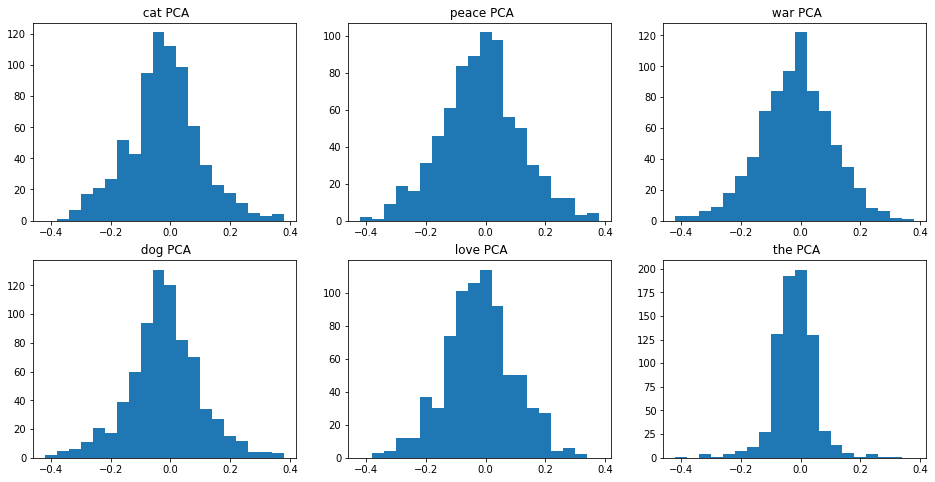

In [27]:
from sklearn.decomposition import PCA
toks = [' cat', ' dog', ' peace', ' love', ' war', ' the']
n_bins = 20

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(2,3)

reduced = torch.tensor(PCA().fit_transform(unembed.T).T)
print(reduced.shape)

for i, tok in enumerate(toks):
    t = encode(tok)
    v = reduced[:,t]
    hist, bin_edges = torch.histogram(v, n_bins, range=(-0.4, 0.4))
    ax[i % 2][i // 2].bar(bin_edges[:-1], hist, bin_edges[1:] - bin_edges[:-1])
    metric = torch.linalg.vector_norm(v, 2, dim=0)
    ax[i % 2][i // 2].set_title(f'{tok} PCA')


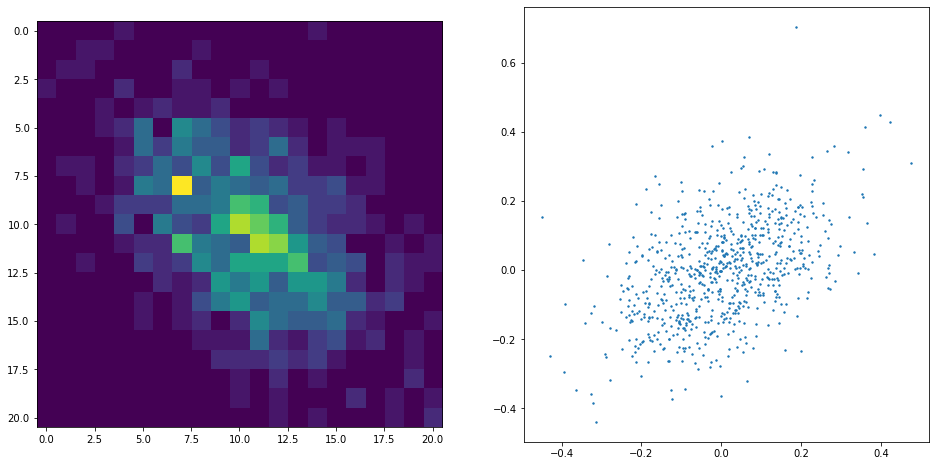

In [67]:
toks = [' cat', ' dog']
t0 = encode(toks[0])
t1 = encode(toks[1])
n_bins = 21
hist2d = torch.zeros((n_bins, n_bins))
for i in range(d_M):
    x = min(n_bins-1, max(0, int(unembed[i,t0].item() / 0.4 * ((n_bins - 1) / 2) + ((n_bins + 1) / 2))))
    y = min(n_bins-1, max(0, int(unembed[i,t1].item() / 0.4 * ((n_bins - 1) / 2) + ((n_bins + 1) / 2))))
    hist2d[x,y] += 1

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(hist2d)
ax[1].scatter(unembed[:,t0], unembed[:,t1], s=2)

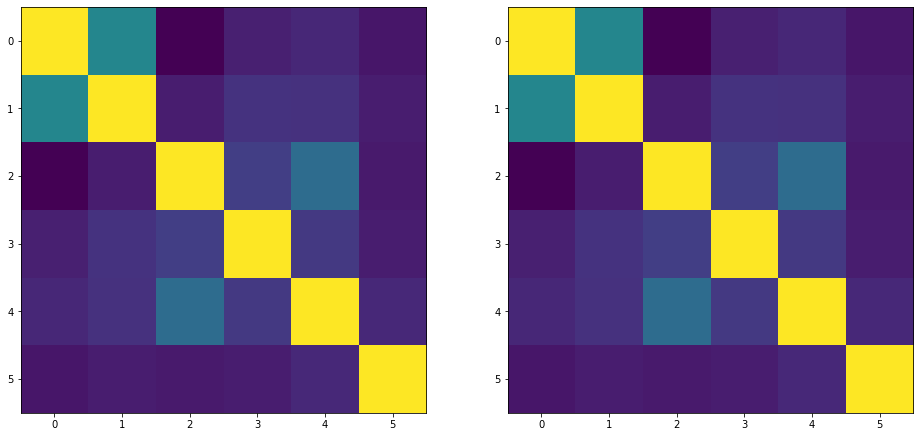

In [73]:
toks = [' cat', ' dog', ' peace', ' love', ' war', ' the']
ts = torch.tensor([encode(tok) for tok in toks])
coef = torch.corrcoef(unembed[:,ts].T)
dots = torch.matmul(unembed_norm[:,ts].T, unembed_norm[:,ts])

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(coef)
ax[1].imshow(dots)


/home/giles/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


<BarContainer object of 768 artists>

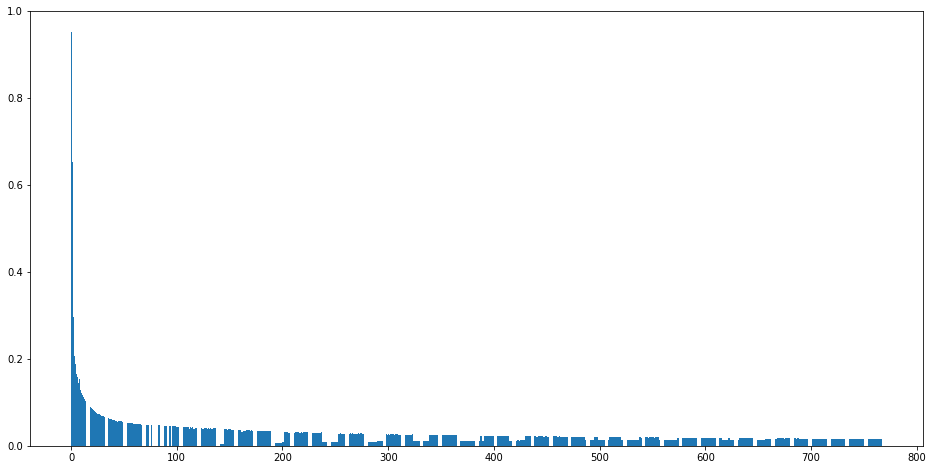

In [80]:
cov = torch.cov(unembed)
eigval, eigvec = torch.linalg.eig(cov)
plt.rcParams['figure.figsize'] = [16, 8]
plt.bar(range(d_M), eigval)